In [356]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import itertools
%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [322]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import keras_metrics
import multiap_cnn_model
import time  
import ap_cnn_model


In [323]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [324]:
def extract_patterns(data,extract=False):
    if(extract):
        patterns = {}
        for index, row in data.iterrows():
            patterns[row['index']] = set(get_pattern([row['text']])[0].values())
            print('Extracted pattern from '+ row['index'] + ' index:'+ str(index))
            print('Size: ', len(patterns[row['index']]), 'Patterns size', len(patterns))
        try:
            print('Saving Pickle')
            with open('pickles/patterns/pattern.pickle','wb') as f:
                save = {
                    'patterns' : patterns
                }
                pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
                print('Successfully saved in pattern.pickle')
                return patterns
        except Exception as e:
            print('Unable to save data to pickle', e)
            print('Patterns probably not saved.')
            return patterns
    else:
        try:
            with open('pickles/patterns/pattern.pickle','rb') as f:
                save = pickle.load(f)
                patterns = save['patterns']
                del save
                returning = {}
                for key in list(data['index']):
                    returning[key] = patterns[key]
                return returning
        except Exception as e:
            print('Error loading base datasets pickle: ', e)
            
def clean_text(text, remove_actions= True):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    if(remove_actions):
        text = re.sub(r" ?\[[^)]+\]", "", text)
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]


def remove_empty_patterns(data,patterns):
    empty_patterns = [k for k, v in patterns.items() if len(v) < 1]
    patterns = { k:v for k, v in patterns.items() if len(v) >= 1 }
    data = filter(lambda x: x[1]['index'] not in empty_patterns ,data.iterrows())
    data = pd.DataFrame.from_items(data).T
    return data,patterns

def remove_multiwildcard(patterns):
    for index, patt in patterns.items():
        flt_patt = {p for p in patt if p.split(' ').count('.+') == 1}
        patterns[index] = flt_patt
    return patterns

def load_data(word_count,emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    #Remove rows that don't have Alignment file
    try:
        data = data.drop(no_alignment_file)
    except Exception as e:
        print('Error at: ',e)
    # Remove rows that have wrong Alignment file
    try:
        data = data.drop(wrong_alignment)
    except Exception as e:
        print('Error at: ',e)
#     Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
    patterns = extract_patterns(data)
    data,patterns = remove_empty_patterns(data,patterns)
    patterns = remove_multiwildcard(patterns)
    return data,patterns

def load_acoustic_fullmatrices(extraction_type = 'full',extract_fd = False):
    if(extraction_type in ['full','wc','cw']):
        try:
            if(extract_fd):
                fullmfcc_matrix_fd = None
                fullrmse_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix FULLDATA')
                fullzcr_matrix_fd = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix_fd.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix FULLDATA')   
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix_fd.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix_fd = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices FULLDATA')
                fullmfcc_matrix_fd.append(fullrmse_matrix_fd)
                fullmfcc_matrix_fd.append(fullzcr_matrix_fd)
                return fullmfcc_matrix_fd
            else:
                fullmfcc_matrix = None
                fullrmse_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_rmse_matrix.pickle')
                print('Successfully loaded '+extraction_type+' RMSE Matrix')   
                fullzcr_matrix = pd.read_pickle('pickles/patterns/'+extraction_type+'_zcr_matrix.pickle')
                print('Successfully loaded '+extraction_type+' ZCR Matrix')
                with open('pickles/patterns/'+extraction_type+'_mfcc20_matrix.pickle','rb') as f:
                    save = pickle.load(f)
                    fullmfcc_matrix = save['multimatrix']
                    del save
                print('Successfully loaded '+extraction_type+' MFCC Matrices') 
                fullmfcc_matrix.append(fullrmse_matrix)
                fullmfcc_matrix.append(fullzcr_matrix)
                return fullmfcc_matrix
        except Exception as e:
            print('Error loading matrix: ', e)
    else:
        print('Error')
        return None,None


In [325]:
# DATASET
seed = 7
np.random.seed(seed)
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}

data, patterns = load_data(2,emotional_mapping)
# x_train, x_test, y_train, y_test = train_test_split(data, data.emotion_code, test_size=TEST_SIZE)
try:
    with open('pickles/matrix_basedata.pickle','rb') as f:
        save = pickle.load(f)
        X_train = save['X_train']
        X_test = save['X_test']
        y_train = save['y_train']
        y_test = save['y_test']
        del save
except Exception as e:
    print('Error loading base datasets pickle: ', e)

    
data.groupby('emotion').count()['index']

Error at:  labels [4764] not contained in axis


emotion
ang    1178
hap     722
neu    1566
sad    1008
Name: index, dtype: int64

## Create y labels for Binary Models

In [326]:
# y_train = pd.get_dummies(y_train).values
# y_test = pd.get_dummies(y_test).values
ang_mapping = {0:1,1:0,2:0,3:0}
hap_mapping = {0:0,1:1,2:0,3:0}
sad_mapping = {0:0,1:0,2:1,3:0}

ang_train = y_train.map(ang_mapping)
ang_test = y_test.map(ang_mapping)
hap_train = y_train.map(hap_mapping)
hap_test = y_test.map(hap_mapping)
sad_train = y_train.map(sad_mapping)
sad_test = y_test.map(sad_mapping)

In [327]:
ang_train = pd.get_dummies(ang_train).values
ang_test = pd.get_dummies(ang_test).values
sad_train = pd.get_dummies(sad_train).values
sad_test = pd.get_dummies(sad_test).values
hap_train = pd.get_dummies(hap_train).values
hap_test = pd.get_dummies(hap_test).values

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

## Load Acoustic Matrices

In [328]:
# full_matrices = load_acoustic_fullmatrices(extraction_type='full')
# wc_matrices = load_acoustic_fullmatrices(extraction_type='wc')
# cw_matrices = load_acoustic_fullmatrices(extraction_type='cw')
##################### FULLDATA ACOUSTIC MATRICES ###################################
full_matrices = load_acoustic_fullmatrices(extraction_type='full',extract_fd = True)
wc_matrices = load_acoustic_fullmatrices(extraction_type='wc',extract_fd = True)
cw_matrices = load_acoustic_fullmatrices(extraction_type='cw',extract_fd = True)
########################################################################################
RMSE_INDEX = 20
ZCR_INDEX = 21
###########################################################################################

em_df = pd.read_pickle('pickles/patterns/pfief_matrix.pickle')

patterns_list = np.array(list(em_df.index))
print(len(em_df),len(full_matrices),len(wc_matrices),len(cw_matrices))

Successfully loaded full RMSE Matrix FULLDATA
Successfully loaded full ZCR Matrix FULLDATA
Successfully loaded full MFCC Matrices FULLDATA
Successfully loaded wc RMSE Matrix FULLDATA
Successfully loaded wc ZCR Matrix FULLDATA
Successfully loaded wc MFCC Matrices FULLDATA
Successfully loaded cw RMSE Matrix FULLDATA
Successfully loaded cw ZCR Matrix FULLDATA
Successfully loaded cw MFCC Matrices FULLDATA
5853 22 22 22


In [329]:
def get_frequency_vectors(data,patterns_list):
    patterns = extract_patterns(data)
    transcript_order = list(data['index'])
    frequency_vectors = []
    for index in patterns:
        frequency_vectors.append(np.isin(patterns_list,np.array(list(patterns[index]))))
    vectors = pd.DataFrame(frequency_vectors,columns=patterns_list,index=patterns.keys())
    vectors = vectors.loc[transcript_order]
    vectors = vectors * 1
    return vectors

vectors = get_frequency_vectors(X_train,patterns_list)
test_vectors = get_frequency_vectors(X_test,patterns_list)

In [330]:
vectors.head(1)

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses04F_script03_2_M001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
test_vectors.head(1)

,.+ a,.+ a big,.+ a bit,.+ a day,.+ a dog,.+ a few,.+ a good,.+ a guy,.+ a little,.+ a lot,...,your .+ with,your .+ you,your .+ your,your a .+,your life .+,your name .+,your own .+,yours .+,yourself .+,yourself a .+
Ses05F_impro02_F024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Parameter

In [331]:
# EMBEDDING
EMBEDDING_DIM  = 4
MAX_SEQ_LENGTH = 170

# MODEL
FILTER_SIZES   = [1,1,1]
FEATURE_MAPS   = [150,150,150]
DROPOUT_RATE   = 0.2

# LEARNING
BATCH_SIZE     = 50
NB_EPOCHS      = 50
RUNS           = 5
VAL_SIZE       = 0.2
LEARNING_RATE  = 0.01

# Build Baseline Frequency Vectors

In [349]:
result = [np.sum(x[1]) for x in vectors.iterrows()]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

    
data = []
test_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    data.append(pad)
    
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    test_data.append(pad)


Text informations:
max length: 165 / min length: 1 / mean length: 25 / limit length: 170


In [335]:
np.array(data).shape, y_train.shape, np.array(test_data).shape, y_test.shape

((3366, 170, 4), (3366, 4), (842, 170, 4), (842, 4))

# Conv1D Baseline

## Binary Models Training

In [40]:
# histories = []

# start_time = time.time()
# emb_layer = None

# ang_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# ang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = ang_model.fit(
#     [data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

# ####### SADNESS #######
# start_time = time.time()
# sad_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# sad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = sad_model.fit(
#     [data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

# ####### HAPPY #######
# start_time = time.time()
# hap_model = ap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo=2
# )

# hap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = hap_model.fit(
#     [data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration finished' )
# print("--- %s seconds on ---" % (time.time() - start_time))

Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 8s 2ms/step - loss: 1.3185 - acc: 0.6806 - precision: 0.6806 - recall: 0.6806 - val_loss: 1.2923 - val_acc: 0.7268 - val_precision: 0.7268 - val_recall: 0.7268
Epoch 2/50
3366/3366 [==============================] - 6s 2ms/step - loss: 1.2741 - acc: 0.7285 - precision: 0.7285 - recall: 0.7285 - val_loss: 1.2726 - val_acc: 0.7280 - val_precision: 0.7280 - val_recall: 0.7280
Epoch 3/50
3366/3366 [==============================] - 6s 2ms/step - loss: 1.2547 - acc: 0.7329 - precision: 0.7329 - recall: 0.7329 - val_loss: 1.2549 - val_acc: 0.7268 - val_precision: 0.7268 - val_recall: 0.7268
Epoch 4/50
3366/3366 [==============================] - 6s 2ms/ste

3366/3366 [==============================] - 6s 2ms/step - loss: 0.9937 - acc: 0.8523 - precision: 0.8523 - recall: 0.8523 - val_loss: 1.0391 - val_acc: 0.8337 - val_precision: 0.8337 - val_recall: 0.8337
Epoch 24/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9863 - acc: 0.8523 - precision: 0.8523 - recall: 0.8523 - val_loss: 1.0342 - val_acc: 0.8361 - val_precision: 0.8361 - val_recall: 0.8361
Epoch 25/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9799 - acc: 0.8520 - precision: 0.8520 - recall: 0.8520 - val_loss: 1.0299 - val_acc: 0.8385 - val_precision: 0.8385 - val_recall: 0.8385
Epoch 26/50
3366/3366 [==============================] - 7s 2ms/step - loss: 0.9769 - acc: 0.8553 - precision: 0.8553 - recall: 0.8553 - val_loss: 1.0246 - val_acc: 0.8385 - val_precision: 0.8385 - val_recall: 0.8385
Epoch 27/50
3366/3366 [==============================] - 6s 2ms/step - loss: 0.9671 - acc: 0.8610 - precision: 0.8610 - recall: 0.8610 - val_los

Epoch 47/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9132 - acc: 0.8535 - precision: 0.8535 - recall: 0.8535 - val_loss: 0.9908 - val_acc: 0.8207 - val_precision: 0.8207 - val_recall: 0.8207
Epoch 48/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9080 - acc: 0.8580 - precision: 0.8580 - recall: 0.8580 - val_loss: 0.9895 - val_acc: 0.8254 - val_precision: 0.8254 - val_recall: 0.8254
Epoch 49/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9005 - acc: 0.8559 - precision: 0.8559 - recall: 0.8559 - val_loss: 0.9847 - val_acc: 0.8230 - val_precision: 0.8230 - val_recall: 0.8230
Epoch 50/50
3366/3366 [==============================] - 8s 2ms/step - loss: 0.9012 - acc: 0.8613 - precision: 0.8613 - recall: 0.8613 - val_loss: 0.9855 - val_acc: 0.8254 - val_precision: 0.8254 - val_recall: 0.8254
Iteration finished
--- 401.99599719047546 seconds on ---


## Binary Models Conf Matrix, Precision and Recall

In [119]:
# ang_test_predictions = ang_model.predict([test_data],verbose=1)
# sad_test_predictions = sad_model.predict([test_data],verbose=1)
# hap_test_predictions = hap_model.predict([test_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)

842/842 [==============================] - 4s 5ms/step


In [ ]:
# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Overall Model Training

In [360]:
histories = []
start_time = time.time()
model = ap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo=4
)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = model.fit(
    [data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print('Iteration finished' )
print("--- %s seconds on ---" % (time.time() - start_time))

# binarycross - val_acc: 0.7625 - val_precision: 0.9852 - val_recall: 0.0511
# binarycross with categorical accuracy - val_categorical_accuracy: 0.4857 - val_precision: 1.0000 - val_recall: 0.0570
# categorical cross - val_categorical_accuracy: 0.5380 - val_precision: 0.9901 - val_recall: 0.0986

Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.2638 - acc: 0.7507 - val_loss: 1.2445 - val_acc: 0.7509
Epoch 2/50
3366/3366 [==============================] - 7s 2ms/step - loss: 1.2219 - acc: 0.7552 - val_loss: 1.2181 - val_acc: 0.7571
Epoch 3/50
3366/3366 [==============================] - 7s 2ms/step - loss: 1.1895 - acc: 0.7625 - val_loss: 1.1937 - val_acc: 0.7607
Epoch 4/50
3366/3366 [==============================] - 8s 2ms/step - loss: 1.1583 - acc: 0.7701 - val_loss: 1.1733 - val_acc: 0.7660
Epoch 5/50
3366/3366 [==============================] - 7s 2ms/step - loss: 1.1301 - acc: 0.7791 - val_loss: 1.1528 - val_acc: 0.7693
Epoch 6/50
3366/3366 [=====================

In [373]:
# model.save('cnn_models/binbaseline.h5')

baseline_model = keras.models.load_model('cnn_models/binbaseline.h5')
baseline_predictions = baseline_model.predict([test_data],verbose=1)

842/842 [==============================] - 3s 3ms/step


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 0s 452us/step
Normalized confusion matrix


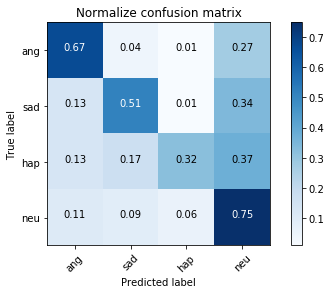

Precision:  0.6191013793208765
Recall:  0.6021377672209026
Accuracy:  0.6021377672209026


In [359]:
test_predictions = model.predict([test_data],verbose=1)
y_pred = np.argmax(test_predictions,axis=1)
y_true = np.argmax(y_test,axis=1)
cnf_matrix = confusion_matrix(y_true,y_pred)
precision = precision_score(y_true,y_pred,average="weighted")
recall = recall_score(y_true,y_pred,average="weighted")
accuracy = accuracy_score(y_true,y_pred)
EMO_SET = ['ang','sad','hap','neu']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=EMO_SET,normalize=True, title='Normalize confusion matrix')
plt.show()
print('Precision: ',precision)
print('Recall: ',recall)
print('Accuracy: ',accuracy)



In [99]:
for i,val in enumerate(EMO_SET):
    diag = cnf_matrix[i][i]
    for_recall = sum(cnf_matrix[i,:])
    for_precision = sum(cnf_matrix[:,i])
    print('Emo ' ,val, diag/for_precision, diag/for_recall)
print('Overall Model',precision, recall)


Emo  ang 0.7019230769230769 0.6347826086956522
Emo  sad 0.5942857142857143 0.5502645502645502
Emo  hap 0.7090909090909091 0.2746478873239437
Emo  neu 0.5297029702970297 0.7615658362989324
Overall Model 0.6214961418487911 0.5973871733966746


Training: 	0.9148 loss / 0.8415 acc
Validation: 	0.9782 loss / 0.8141 acc


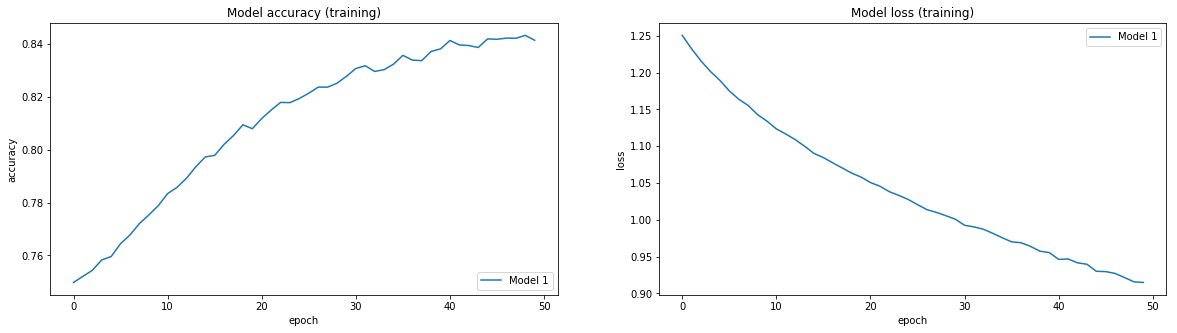

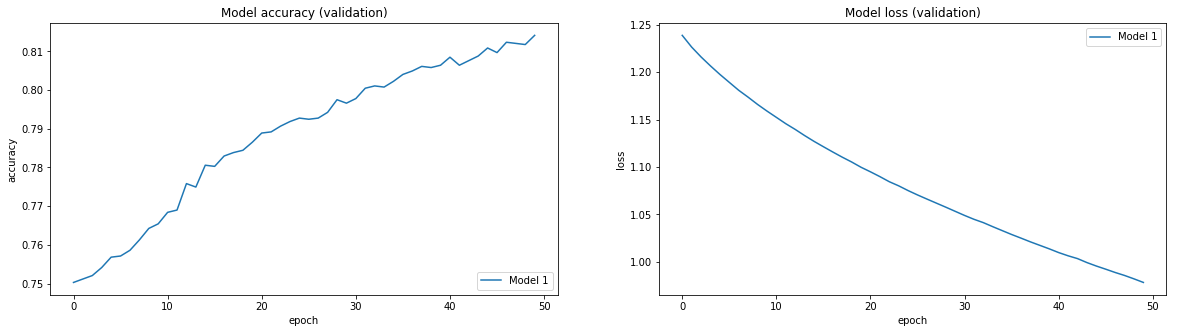

In [56]:
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

# Multichannel CNN - RMSE

## Build Multichannel Frequency Vectors

In [59]:
acoustic_matrix = full_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])



In [60]:
acoustic_matrix = cw_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

In [61]:
acoustic_matrix = wc_matrices[RMSE_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

In [62]:
np.array(full_data).shape, y_train.shape, np.array(test_full_data).shape, y_test.shape

((3366, 2, 170, 4), (3366, 4), (842, 2, 170, 4), (842, 4))

In [63]:
np.array(cw_data).shape, np.array(wc_data).shape, np.array(test_cw_data).shape, np.array(test_wc_data).shape

((3366, 2, 170, 4), (3366, 2, 170, 4), (842, 2, 170, 4), (842, 2, 170, 4))

In [251]:
def run_models(full_data,test_full_data, wc_data, test_wc_data, cw_data, test_cw_data, loss='binary_crossentropy',num_emo = 4):
    histories = []
    print('Running iteration 1/3')
    start_time = time.time()

    wc_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo= num_emo
    )

    wc_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = wc_model.fit(
        [wc_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_wc_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print("--- %s seconds on ---" % (time.time() - start_time))
    #######

    print('Running iteration 2/3')
    start_time = time.time()

    cw_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo= num_emo
    )

    cw_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = cw_model.fit(
        [cw_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_cw_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print("--- %s seconds on ---" % (time.time() - start_time))
    #######
    print('Running iteration 3/3')
    start_time = time.time()

    full_model = multiap_cnn_model.build_cnn(
        embedding_dim= EMBEDDING_DIM,
        filter_sizes = FILTER_SIZES,
        feature_maps = FEATURE_MAPS,
        num_channels= NUM_CHANNELS,
        max_seq_length = MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE,
        num_emo = num_emo
    )

    full_model.compile(
        loss=loss,
        optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
        metrics=['accuracy']
    )

    history = full_model.fit(
        [full_data], y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=([test_full_data], y_test),
        callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                                   verbose=0, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration 3/3')
    print("--- %s seconds on ---" % (time.time() - start_time))
    return full_model, wc_model, cw_model, histories

## Binary Models Training - Wild Cards Feature Extraction

In [162]:
# ###### ANGER #######
# histories = []
# print('Running iteration 1/1' )
# start_time = time.time()
# emb_layer = None

# wcang_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wcang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wcang_model.fit(
#     [wc_data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### SADNESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# wcsad_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wcsad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wcsad_model.fit(
#     [wc_data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### HAPINESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# wchap_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# wchap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = wchap_model.fit(
#     [wc_data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_wc_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

## Binary Models ConfMatrix, Precision and Recall - Wild Cards Feature Extraction

In [163]:
# ang_test_predictions = wcang_model.predict([test_wc_data],verbose=1)
# sad_test_predictions = wcsad_model.predict([test_wc_data],verbose=1)
# hap_test_predictions = wchap_model.predict([test_wc_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)



In [164]:
# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Binary Models Training - Content Word Feature Extraction

In [165]:
# ###### ANGER #######
# histories = []
# print('Running iteration 1/1' )
# start_time = time.time()
# emb_layer = None

# cwang_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwang_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwang_model.fit(
#     [cw_data], ang_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], ang_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### SADNESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# cwsad_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwsad_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwsad_model.fit(
#     [cw_data], sad_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], sad_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

# ###### HAPINESS #######
# histories = []
# print('Running iteration 1/1')
# start_time = time.time()
# emb_layer = None

# cwhap_model = multiap_cnn_model.build_cnn(
#     embedding_dim= EMBEDDING_DIM,
#     filter_sizes = FILTER_SIZES,
#     feature_maps = FEATURE_MAPS,
#     num_channels= NUM_CHANNELS,
#     max_seq_length = MAX_SEQ_LENGTH,
#     dropout_rate=DROPOUT_RATE,
#     num_emo= 2
# )

# cwhap_model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
#     metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall()]
# )

# history = cwhap_model.fit(
#     [cw_data], hap_train,
#     epochs=NB_EPOCHS,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     validation_data=([test_cw_data], hap_test),
#     callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
#                                verbose=0, save_best_only=True, mode='min'),
#                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#               ]
# )
# histories.append(history.history)
# print('Iteration 1')
# print("--- %s seconds on ---" % (time.time() - start_time))

## Binary Models ConfMatrix, Precision and Recall - Content Words Feature Extraction

In [166]:

# ang_cnf_matrix = confusion_matrix(ang_y_true,ang_y_pred)
# ang_test_predictions = cwang_model.predict([test_cw_data],verbose=1)
# sad_test_predictions = cwsad_model.predict([test_cw_data],verbose=1)
# hap_test_predictions = cwhap_model.predict([test_cw_data],verbose=1)

# ang_y_pred = np.argmax(ang_test_predictions,axis=1)
# ang_y_true = np.argmax(ang_test,axis=1)

# sad_y_pred = np.argmax(sad_test_predictions,axis=1)
# sad_y_true = np.argmax(sad_test,axis=1)

# hap_y_pred = np.argmax(hap_test_predictions,axis=1)
# hap_y_true = np.argmax(hap_test,axis=1)

# sad_cnf_matrix = confusion_matrix(sad_y_true,sad_y_pred)
# hap_cnf_matrix = confusion_matrix(hap_y_true,hap_y_pred)

# ang_precision =precision_score(ang_y_true,ang_y_pred)
# ang_recall = recall_score(ang_y_true,ang_y_pred)
# hap_precision =precision_score(hap_y_true,hap_y_pred)
# hap_recall = recall_score(hap_y_true,hap_y_pred)
# sad_precision =precision_score(sad_y_true,sad_y_pred)
# sad_recall = recall_score(sad_y_true,sad_y_pred)
# ANG_SET = ['not_ang', 'ang']
# SAD_SET = ['not_sad', 'sad']
# HAP_SET = ['not_hap', 'hap']
# plt.figure()
# plot_confusion_matrix(ang_cnf_matrix, classes=ANG_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Anger')
# print('Precision: ',ang_precision)
# print('Recall: ',ang_recall)

# plt.figure()
# plot_confusion_matrix(sad_cnf_matrix, classes=SAD_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Sadness')
# print('Precision: ',sad_precision)
# print('Recall: ',sad_recall)

# plt.figure()
# plot_confusion_matrix(hap_cnf_matrix, classes=HAP_SET, normalize=False,
#                       title='Normalized confusion matrix')

# plt.show()
# print('Happiness')
# print('Precision: ',hap_precision)
# print('Recall: ',hap_recall)



## Overall Model Training

In [70]:
full_model, wc_model, cw_model , histories = run_model(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 15s 4ms/step - loss: 1.2801 - acc: 0.7495 - precision: 0.3375 - recall: 0.0039 - val_loss: 1.2670 - val_acc: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2575 - acc: 0.7516 - precision: 0.6494 - recall: 0.0134 - val_loss: 1.2549 - val_acc: 0.7509 - val_precision: 0.4751 - val_recall: 0.0036
Epoch 3/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2439 - acc: 0.7548 - precision: 0.8061 - recall: 0.0261 - val_loss: 1.2447 - val_acc: 0.7515 - val_precision: 0.7126 - val_recall: 0.0059
Epoch 4/50
3366/3366 [===========

Epoch 23/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.0427 - acc: 0.8148 - precision: 0.9002 - recall: 0.2914 - val_loss: 1.0873 - val_acc: 0.7898 - val_precision: 0.8927 - val_recall: 0.1805
Epoch 24/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.0360 - acc: 0.8141 - precision: 0.8845 - recall: 0.2950 - val_loss: 1.0823 - val_acc: 0.7916 - val_precision: 0.8847 - val_recall: 0.1912
Epoch 25/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0331 - acc: 0.8148 - precision: 0.8770 - recall: 0.3010 - val_loss: 1.0776 - val_acc: 0.7925 - val_precision: 0.8981 - val_recall: 0.1912
Epoch 26/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0228 - acc: 0.8197 - precision: 0.8888 - recall: 0.3188 - val_loss: 1.0731 - val_acc: 0.7942 - val_precision: 0.8775 - val_recall: 0.2055
Epoch 27/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0188 - acc: 0.8196 - precision: 0.8867 - recall:

Epoch 9/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.1307 - acc: 0.7695 - precision: 0.9115 - recall: 0.0865 - val_loss: 1.1482 - val_acc: 0.7631 - val_precision: 1.0000 - val_recall: 0.0523
Epoch 10/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1207 - acc: 0.7729 - precision: 0.9010 - recall: 0.1025 - val_loss: 1.1423 - val_acc: 0.7648 - val_precision: 0.9644 - val_recall: 0.0618
Epoch 11/50
3366/3366 [==============================] - 12s 3ms/step - loss: 1.1124 - acc: 0.7776 - precision: 0.9272 - recall: 0.1197 - val_loss: 1.1348 - val_acc: 0.7660 - val_precision: 1.0000 - val_recall: 0.0641
Epoch 12/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1012 - acc: 0.7798 - precision: 0.9109 - recall: 0.1319 - val_loss: 1.1285 - val_acc: 0.7660 - val_precision: 0.9717 - val_recall: 0.0665
Epoch 13/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.0926 - acc: 0.7845 - precision: 0.8989 - recall: 

In [71]:
full_model.save('cnn_models/binrmse_full.h5')
cw_model.save('cnn_models/binrmse_cw.h5')
wc_model.save('cnn_models/binrmse_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

In [367]:
def get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data):
    full_test_predictions = full_model.predict([test_full_data],verbose=1)
    cw_test_predictions = cw_model.predict([test_cw_data],verbose=1)
    wc_test_predictions = wc_model.predict([test_wc_data],verbose=1)

    full_y_pred = np.argmax(full_test_predictions,axis=1)
    full_y_true = np.argmax(y_test,axis=1)

    cw_y_pred = np.argmax(cw_test_predictions,axis=1)
    cw_y_true = np.argmax(y_test,axis=1)

    wc_y_pred = np.argmax(wc_test_predictions,axis=1)
    wc_y_true = np.argmax(y_test,axis=1)
    
    full_cnf_matrix = confusion_matrix(full_y_true,full_y_pred)
    cw_cnf_matrix = confusion_matrix(cw_y_true,cw_y_pred)
    wc_cnf_matrix = confusion_matrix(wc_y_true,wc_y_pred)

    full_precision =precision_score(full_y_true,full_y_pred,average='weighted')
    full_recall = recall_score(full_y_true,full_y_pred,average='weighted')
    cw_precision =precision_score(cw_y_true,cw_y_pred,average='weighted')
    cw_recall = recall_score(cw_y_true,cw_y_pred,average='weighted')
    wc_precision =precision_score(wc_y_true,wc_y_pred,average='weighted')
    wc_recall = recall_score(wc_y_true,wc_y_pred,average='weighted')
    full_accuracy = accuracy_score(full_y_true,full_y_pred)
    cw_accuracy = accuracy_score(cw_y_true,cw_y_pred)
    wc_accuracy = accuracy_score(wc_y_true,wc_y_pred)
    plt.figure()
    plot_confusion_matrix(full_cnf_matrix, classes=EMO_SET, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

    plt.figure()
    plot_confusion_matrix(cw_cnf_matrix, classes=EMO_SET, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

    plt.figure()
    plot_confusion_matrix(wc_cnf_matrix, classes=EMO_SET, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    print('Accuracy')
    print('Full',full_accuracy)
    print('CW',cw_accuracy)
    print('WC',wc_accuracy)
    return full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, [full_precision,wc_precision,cw_precision],[full_recall,wc_recall,cw_recall]


EMO_SET = ['ang','sad','hap','neu']


Confusion matrix, without normalization


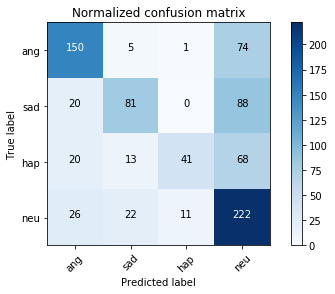

Full
Precision:  0.634329233158318
Recall:  0.5866983372921615
Confusion matrix, without normalization


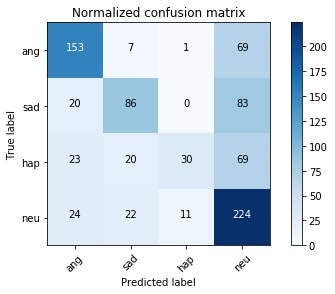

CW
Precision:  0.6214136673329607
Recall:  0.5855106888361045
Confusion matrix, without normalization


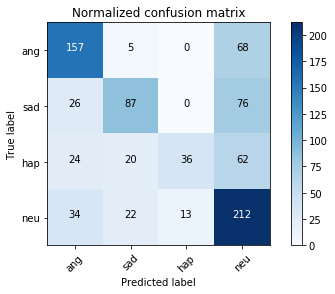

Happiness
Precision:  0.61684828639415
Recall:  0.5843230403800475


In [75]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix,precisions,recalls = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [263]:
def get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix):
    for i,val in enumerate(EMO_SET):
        diag = full_cnf_matrix[i][i]
        for_recall = sum(full_cnf_matrix[i,:])
        for_precision = sum(full_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',', diag/for_recall)
    print('-')
    for i,val in enumerate(EMO_SET):
        diag = wc_cnf_matrix[i][i]
        for_recall = sum(wc_cnf_matrix[i,:])
        for_precision = sum(wc_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',' ,diag/for_recall)
    print('-')
    for i,val in enumerate(EMO_SET):
        diag = cw_cnf_matrix[i][i]
        for_recall = sum(cw_cnf_matrix[i,:])
        for_precision = sum(cw_cnf_matrix[:,i])
        print('Emo ' ,val, diag/for_precision,',', diag/for_recall)
    
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)

Emo  ang 0.7931034482758621 , 0.7
Emo  sad 0.6795580110497238 , 0.6507936507936508
Emo  hap 0.8478260869565217 , 0.2746478873239437
Emo  neu 0.5558252427184466 , 0.8149466192170819
-
Emo  ang 0.6796875 , 0.7565217391304347
Emo  sad 0.7980769230769231 , 0.43915343915343913
Emo  hap 0.7682926829268293 , 0.44366197183098594
Emo  neu 0.565 , 0.8042704626334519
-
Emo  ang 0.8153846153846154 , 0.691304347826087
Emo  sad 0.7279411764705882 , 0.5238095238095238
Emo  hap 0.8727272727272727 , 0.3380281690140845
Emo  neu 0.5328947368421053 , 0.8647686832740213


# Multichannel CNN - ZCR

## Build Multichannel Frequency Vectors

In [222]:
acoustic_matrix = full_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[ZCR_INDEX]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

## Overall Model Training

In [134]:
histories = []
print('Running iteration 1/3')
start_time = time.time()

wc_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

wc_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = wc_model.fit(
    [wc_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_wc_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print("--- %s seconds on ---" % (time.time() - start_time))
#######

print('Running iteration 2/3')
start_time = time.time()

cw_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

cw_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = cw_model.fit(
    [cw_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_cw_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print("--- %s seconds on ---" % (time.time() - start_time))
#######
print('Running iteration 3/3')
start_time = time.time()

full_model = multiap_cnn_model.build_cnn(
    embedding_dim= EMBEDDING_DIM,
    filter_sizes = FILTER_SIZES,
    feature_maps = FEATURE_MAPS,
    num_channels= NUM_CHANNELS,
    max_seq_length = MAX_SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE,
    num_emo= 4
)

full_model.compile(
    loss='binary_crossentropy',
    optimizer=Adadelta(clipvalue=3,lr=LEARNING_RATE),
    metrics=['accuracy']
)

history = full_model.fit(
    [full_data], y_train,
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=([test_full_data], y_test),
    callbacks=[ModelCheckpoint('model-1.h5', monitor='val_loss',
                               verbose=0, save_best_only=True, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
              ]
)
histories.append(history.history)
print('Iteration 3/3')
print("--- %s seconds on ---" % (time.time() - start_time))

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 14s 4ms/step - loss: 1.2492 - acc: 0.7496 - val_loss: 1.2413 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2338 - acc: 0.7510 - val_loss: 1.2308 - val_acc: 0.7500
Epoch 3/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2203 - acc: 0.7527 - val_loss: 1.2209 - val_acc: 0.7503
Epoch 4/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.2055 - acc: 0.7562 - val_loss: 1.2117 - val_acc: 0.7533
Epoch 5/50
3366/3366 [==============================] - 12s 4ms/step - loss: 1.1929 - acc: 0.7610 - val_loss: 1.2028 - val_acc: 0.7530
Epoch 6/50
3366/3

Epoch 14/50
3366/3366 [==============================] - 22s 6ms/step - loss: 1.1066 - acc: 0.7920 - val_loss: 1.1402 - val_acc: 0.7726
Epoch 15/50
3366/3366 [==============================] - 22s 7ms/step - loss: 1.0998 - acc: 0.7938 - val_loss: 1.1343 - val_acc: 0.7755
Epoch 16/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.0892 - acc: 0.8000 - val_loss: 1.1280 - val_acc: 0.7812
Epoch 17/50
3366/3366 [==============================] - 16s 5ms/step - loss: 1.0839 - acc: 0.7995 - val_loss: 1.1222 - val_acc: 0.7824
Epoch 18/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.0774 - acc: 0.8035 - val_loss: 1.1166 - val_acc: 0.7836
Epoch 19/50
3366/3366 [==============================] - 18s 5ms/step - loss: 1.0686 - acc: 0.8071 - val_loss: 1.1112 - val_acc: 0.7850
Epoch 20/50
3366/3366 [==============================] - 15s 5ms/step - loss: 1.0651 - acc: 0.8061 - val_loss: 1.1059 - val_acc: 0.7880
Epoch 21/50
3366/3366 [=========================

## Save Model or Load Model

In [223]:
# full_model.save('cnn_models/binzcr_full.h5')
# cw_model.save('cnn_models/binzcr_cw.h5')
# wc_model.save('cnn_models/binzcr_wc.h5')

full_model = keras.models.load_model('cnn_models/binzcr_full.h5')
cw_model = keras.models.load_model('cnn_models/binzcr_cw.h5')
wc_model = keras.models.load_model('cnn_models/binzcr_wc.h5')


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 1s 2ms/step
Confusion matrix, without normalization


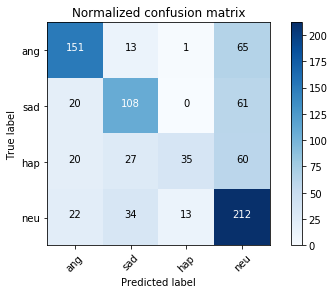

Confusion matrix, without normalization


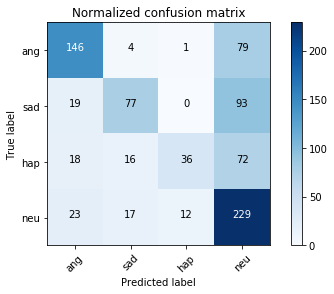

Confusion matrix, without normalization


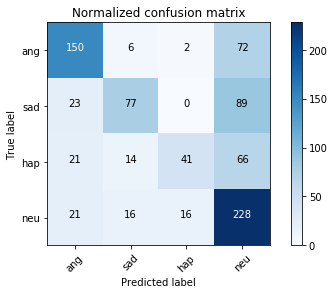

In [224]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix,precisions,recalls = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [225]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print('Overalls')
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.7089201877934272 , 0.6565217391304348
Emo  sad 0.5934065934065934 , 0.5714285714285714
Emo  hap 0.7142857142857143 , 0.24647887323943662
Emo  neu 0.5326633165829145 , 0.7544483985765125
Overall Model 0.6250741718939488 , 0.6009501187648456
-
Emo  ang 0.6976744186046512 , 0.6521739130434783
Emo  sad 0.6814159292035398 , 0.4074074074074074
Emo  hap 0.6949152542372882 , 0.2887323943661972
Emo  neu 0.5010989010989011 , 0.8113879003558719
Overall Model 0.6279566320772266 , 0.5890736342042755
-
Emo  ang 0.7087378640776699 , 0.6347826086956522
Emo  sad 0.6754385964912281 , 0.4074074074074074
Emo  hap 0.7346938775510204 , 0.2535211267605634
Emo  neu 0.48414376321353064 , 0.8149466192170819
Overall Model 0.6306870921020822 , 0.5795724465558195
Overalls
0.6250741718939488 0.6009501187648456
0.6279566320772266 0.5890736342042755
0.6306870921020822 0.5795724465558195


# Multichannel CNN - MFCC1

## Build Multichannel Frequency Vectors

In [229]:
acoustic_matrix = full_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

NUM_CHANNELS = 2

#######################################
full_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    full_data.append([pad, acu_pad])
    
test_full_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_full_data.append([pad, acu_pad])

acoustic_matrix = cw_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

cw_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    cw_data.append([pad, acu_pad])
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_cw_data.append([pad, acu_pad])

acoustic_matrix = wc_matrices[0]
acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))

wc_data = []
for key, row in vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    wc_data.append([pad, acu_pad])
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    ### ACU MATRICES ###
    acu_matrix = acoustic_matrix.loc[row_patt,:].as_matrix()
    acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
    test_wc_data.append([pad, acu_pad])

## Overall Model Training

In [169]:
full_model, wc_model, cw_model , histories = run_models(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 13s 4ms/step - loss: 1.2993 - acc: 0.7490 - val_loss: 1.2837 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2796 - acc: 0.7497 - val_loss: 1.2722 - val_acc: 0.7500
Epoch 3/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2657 - acc: 0.7516 - val_loss: 1.2625 - val_acc: 0.7503
Epoch 4/50
3366/3366 [==============================] - 10s 3ms/step - loss: 1.2515 - acc: 0.7540 - val_loss: 1.2533 - val_acc: 0.7509
Epoch 5/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.2391 - acc: 0.7548 - val_loss: 1.2449 - val_acc: 0.7527
Epoch 6/50
3366/3

Epoch 14/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.1065 - acc: 0.7847 - val_loss: 1.1383 - val_acc: 0.7714
Epoch 15/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0977 - acc: 0.7874 - val_loss: 1.1324 - val_acc: 0.7726
Epoch 16/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0900 - acc: 0.7902 - val_loss: 1.1264 - val_acc: 0.7752
Epoch 17/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0827 - acc: 0.7948 - val_loss: 1.1207 - val_acc: 0.7779
Epoch 18/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0753 - acc: 0.7957 - val_loss: 1.1150 - val_acc: 0.7785
Epoch 19/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0688 - acc: 0.7995 - val_loss: 1.1099 - val_acc: 0.7800
Epoch 20/50
3366/3366 [==============================] - 11s 3ms/step - loss: 1.0612 - acc: 0.8015 - val_loss: 1.1046 - val_acc: 0.7809
Epoch 21/50
3366/3366 [=========================

## Save Model or Load Model

In [230]:
# full_model.save('cnn_models/binmfcc1_full.h5')
# cw_model.save('cnn_models/binmfcc1_cw.h5')
# wc_model.save('cnn_models/binmfcc1_wc.h5')

full_model = keras.models.load_model('cnn_models/binmfcc1_full.h5')
cw_model = keras.models.load_model('cnn_models/binmfcc1_cw.h5')
wc_model = keras.models.load_model('cnn_models/binmfcc1_wc.h5')


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 2s 2ms/step
Confusion matrix, without normalization


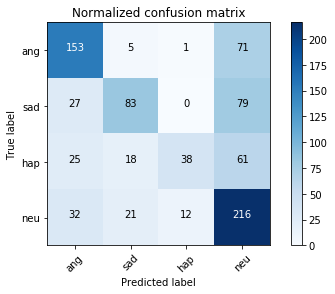

Confusion matrix, without normalization


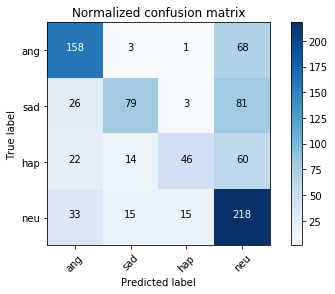

Confusion matrix, without normalization


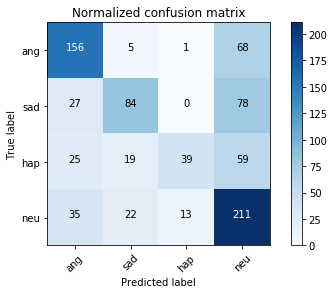

In [231]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [232]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.6455696202531646 , 0.6652173913043479
Emo  sad 0.6535433070866141 , 0.43915343915343913
Emo  hap 0.7450980392156863 , 0.2676056338028169
Emo  neu 0.5058548009367682 , 0.7686832740213523
Overall Model 0.6250741718939488 , 0.6009501187648456
-
Emo  ang 0.6419753086419753 , 0.6782608695652174
Emo  sad 0.6461538461538462 , 0.4444444444444444
Emo  hap 0.7358490566037735 , 0.2746478873239437
Emo  neu 0.5072115384615384 , 0.7508896797153025
Overall Model 0.6279566320772266 , 0.5890736342042755
-
Emo  ang 0.6610878661087866 , 0.6869565217391305
Emo  sad 0.7117117117117117 , 0.41798941798941797
Emo  hap 0.7076923076923077 , 0.323943661971831
Emo  neu 0.5105386416861827 , 0.7758007117437722
Overall Model 0.6306870921020822 , 0.5795724465558195
0.6175175989661013 0.5819477434679335
0.6137700786890254 0.5819477434679335
0.6300681576302368 0.5950118764845606


# Multichannel CNN - MFCC20

## Build Multichannel Frequency Vectors

In [236]:
# acoustic_matrix = full_matrices[RMSE_INDEX]
# acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))
NUM_CHANNELS = 21
acoustic_matrices = full_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
full_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    full_data.append(final)
    
test_full_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_full_data.append(final)

acoustic_matrices = cw_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

cw_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    cw_data.append(final)
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_cw_data.append(final)


acoustic_matrices = wc_matrices[:20].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))


wc_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    wc_data.append(final)
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_wc_data.append(final)

## Overall Model Training

In [255]:
full_model, wc_model, cw_model , histories = run_models(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 327s 97ms/step - loss: 1.2432 - acc: 0.7506 - val_loss: 1.2299 - val_acc: 0.7542
Epoch 2/50
3366/3366 [==============================] - 332s 99ms/step - loss: 1.1953 - acc: 0.7582 - val_loss: 1.2007 - val_acc: 0.7565
Epoch 3/50
3366/3366 [==============================] - 265s 79ms/step - loss: 1.1531 - acc: 0.7710 - val_loss: 1.1781 - val_acc: 0.7696
Epoch 4/50
3366/3366 [==============================] - 248s 74ms/step - loss: 1.1212 - acc: 0.7838 - val_loss: 1.1406 - val_acc: 0.7746
Epoch 5/50
3366/3366 [==============================] - 239s 71ms/step - loss: 1.0888 - acc: 0.7965 - val_loss: 1.1263 - val_acc: 0.7806
Epoch 6

Epoch 6/50
3366/3366 [==============================] - 2031s 603ms/step - loss: 1.0476 - acc: 0.8074 - val_loss: 1.0961 - val_acc: 0.7705
Epoch 7/50
3366/3366 [==============================] - 193s 57ms/step - loss: 1.0236 - acc: 0.8163 - val_loss: 1.0616 - val_acc: 0.7916
Epoch 8/50
3366/3366 [==============================] - 190s 56ms/step - loss: 0.9987 - acc: 0.8272 - val_loss: 1.0496 - val_acc: 0.7957
Epoch 9/50
3366/3366 [==============================] - 192s 57ms/step - loss: 0.9783 - acc: 0.8365 - val_loss: 1.0311 - val_acc: 0.8023
Epoch 10/50
3366/3366 [==============================] - 189s 56ms/step - loss: 0.9595 - acc: 0.8411 - val_loss: 1.0097 - val_acc: 0.8067
Epoch 11/50
3366/3366 [==============================] - 189s 56ms/step - loss: 0.9420 - acc: 0.8455 - val_loss: 1.0033 - val_acc: 0.8106
Epoch 12/50
3366/3366 [==============================] - 190s 57ms/step - loss: 0.9298 - acc: 0.8477 - val_loss: 0.9813 - val_acc: 0.8162
Epoch 13/50
3366/3366 [=============

Epoch 13/50
3366/3366 [==============================] - 219s 65ms/step - loss: 0.9283 - acc: 0.8559 - val_loss: 0.9917 - val_acc: 0.8115
Epoch 14/50
3366/3366 [==============================] - 223s 66ms/step - loss: 0.9123 - acc: 0.8607 - val_loss: 0.9754 - val_acc: 0.8162
Epoch 15/50
3366/3366 [==============================] - 219s 65ms/step - loss: 0.8984 - acc: 0.8642 - val_loss: 0.9642 - val_acc: 0.8210
Epoch 16/50
3366/3366 [==============================] - 223s 66ms/step - loss: 0.8844 - acc: 0.8654 - val_loss: 0.9530 - val_acc: 0.8183
Epoch 17/50
3366/3366 [==============================] - 237s 70ms/step - loss: 0.8742 - acc: 0.8670 - val_loss: 0.9482 - val_acc: 0.8189
Epoch 18/50
3366/3366 [==============================] - 222s 66ms/step - loss: 0.8644 - acc: 0.8677 - val_loss: 0.9301 - val_acc: 0.8242
Epoch 19/50
3366/3366 [==============================] - 219s 65ms/step - loss: 0.8484 - acc: 0.8742 - val_loss: 0.9146 - val_acc: 0.8272
Epoch 20/50
3366/3366 [===========

## Save Model 

In [256]:
# full_model.save('cnn_models/binmfcc20_full.h5')
# cw_model.save('cnn_models/binmfcc20_cw.h5')
# wc_model.save('cnn_models/binmfcc20_wc.h5')

full_model = keras.models.load_model('cnn_models/binmfcc20_full.h5')
cw_model = keras.models.load_model('cnn_models/binmfcc20_cw.h5')
wc_model = keras.models.load_model('cnn_models/binmfcc20_wc.h5')


## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 7s 8ms/step
Confusion matrix, without normalization


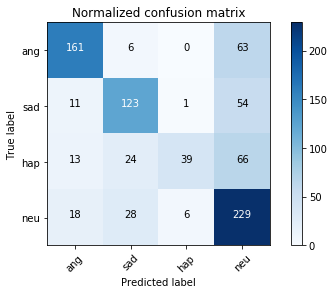

Confusion matrix, without normalization


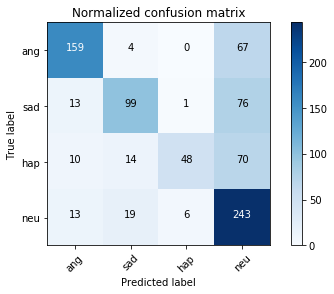

Confusion matrix, without normalization


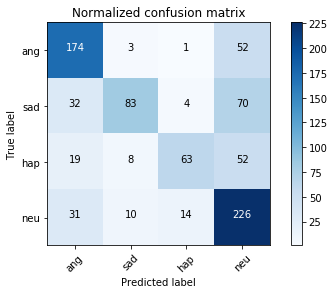

In [261]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix,precisions,recalls = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [264]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])


Emo  ang 0.7931034482758621 , 0.7
Emo  sad 0.6795580110497238 , 0.6507936507936508
Emo  hap 0.8478260869565217 , 0.2746478873239437
Emo  neu 0.5558252427184466 , 0.8149466192170819
-
Emo  ang 0.6796875 , 0.7565217391304347
Emo  sad 0.7980769230769231 , 0.43915343915343913
Emo  hap 0.7682926829268293 , 0.44366197183098594
Emo  neu 0.565 , 0.8042704626334519
-
Emo  ang 0.8153846153846154 , 0.691304347826087
Emo  sad 0.7279411764705882 , 0.5238095238095238
Emo  hap 0.8727272727272727 , 0.3380281690140845
Emo  neu 0.5328947368421053 , 0.8647686832740213
0.6976584973201374 0.6555819477434679
0.6829301952935252 0.6484560570071259
0.711152063742645 0.6520190023752969


# Multichannel CNN - MFCC20 + RMSE

## Build Multichannel Frequency Vectors

In [265]:
# acoustic_matrix = full_matrices[RMSE_INDEX]
# acoustic_matrix = acoustic_matrix.fillna(np.max(acoustic_matrix))
NUM_CHANNELS = 22
acoustic_matrices = full_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
full_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    full_data.append(final)
    
test_full_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_full_data.append(final)

acoustic_matrices = cw_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

cw_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    cw_data.append(final)
    
test_cw_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_cw_data.append(final)

acoustic_matrices = wc_matrices[:21].copy()
for i,am in enumerate(acoustic_matrices):
    acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

wc_data = []
for key, row in vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    wc_data.append(final)
    
test_wc_data = []
for key, row in test_vectors.iterrows():
    final = []
    row_patt = [ i for i,v in row.iteritems() if v == 1]
    row_matrix = em_df.loc[row_patt,:].as_matrix()
    pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
    pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
    final.append(pad)
    ### ACU MATRICES ###
    for i,am in enumerate(acoustic_matrices):
        acu_matrix = am.loc[row_patt,:].as_matrix()
        acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
        final.append(acu_pad)
    test_wc_data.append(final)

## Overall Model Training

In [ ]:
# full_model, wc_model, cw_model , histories = run_models(full_data,test_full_data,wc_data,test_wc_data,cw_data,test_cw_data)

In [266]:
# full_model.save('cnn_models/binmfcc20rmse_full.h5')
# cw_model.save('cnn_models/binmfcc20rmse_cw.h5')
# wc_model.save('cnn_models/binmfcc20rmse_wc.h5')

full_model = keras.models.load_model('cnn_models/binmfcc20rmse_full.h5')
cw_model = keras.models.load_model('cnn_models/binmfcc20rmse_cw.h5')
wc_model = keras.models.load_model('cnn_models/binmfcc20rmse_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 7s 9ms/step
Confusion matrix, without normalization


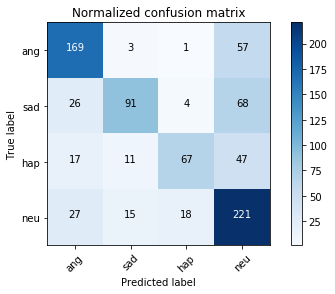

Confusion matrix, without normalization


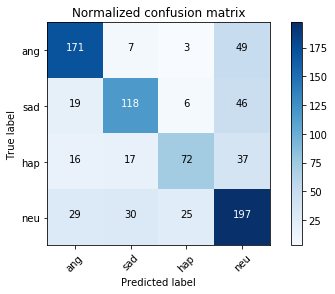

Confusion matrix, without normalization


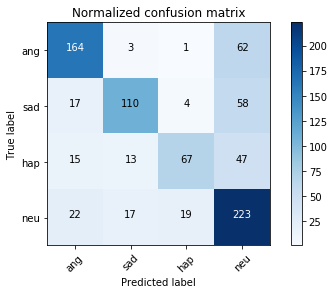

In [268]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions, recalls = get_metrics(full_model,wc_model,cw_model,test_full_data,test_wc_data,test_cw_data)

In [269]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.7071129707112971 , 0.7347826086956522
Emo  sad 0.7583333333333333 , 0.48148148148148145
Emo  hap 0.7444444444444445 , 0.47183098591549294
Emo  neu 0.5623409669211196 , 0.7864768683274022
-
Emo  ang 0.7522935779816514 , 0.7130434782608696
Emo  sad 0.7692307692307693 , 0.582010582010582
Emo  hap 0.7362637362637363 , 0.47183098591549294
Emo  neu 0.5717948717948718 , 0.7935943060498221
-
Emo  ang 0.7276595744680852 , 0.7434782608695653
Emo  sad 0.686046511627907 , 0.6243386243386243
Emo  hap 0.6792452830188679 , 0.5070422535211268
Emo  neu 0.5987841945288754 , 0.701067615658363
[0.6765913373866318, 0.6931543323565378, 0.6671445150553768]
[0.6508313539192399, 0.669833729216152, 0.66270783847981]


# Multichannel CNN - RMSE + ZCR

# Build Multichannel Frequency Vectors

In [270]:
NUM_CHANNELS = 3
type_matrices = [full_matrices,wc_matrices,cw_matrices]
sets_data = []
sets_test_data = []
for dt_data in type_matrices: 
    acoustic_matrices = [dt_data[RMSE_INDEX].copy()]
    acoustic_matrices.append(dt_data[ZCR_INDEX])
    for i,am in enumerate(acoustic_matrices):
        acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
    vector_data = []
    for key, row in vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        vector_data.append(final)

    test_vector_data = []
    for key, row in test_vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        test_vector_data.append(final)
        
    sets_data.append(vector_data)
    sets_test_data.append(test_vector_data)


## Overall Model Training

In [199]:
# full_model, wc_model, cw_model , histories = run_models(sets_data[0],sets_test_data[0],sets_data[1],sets_test_data[1],sets_data[2],sets_test_data[2])

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 24s 7ms/step - loss: 1.2313 - acc: 0.7506 - val_loss: 1.2157 - val_acc: 0.7503
Epoch 2/50
3366/3366 [==============================] - 22s 7ms/step - loss: 1.1886 - acc: 0.7559 - val_loss: 1.1869 - val_acc: 0.7565
Epoch 3/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.1531 - acc: 0.7647 - val_loss: 1.1624 - val_acc: 0.7634
Epoch 4/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.1223 - acc: 0.7730 - val_loss: 1.1407 - val_acc: 0.7672
Epoch 5/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.0951 - acc: 0.7816 - val_loss: 1.1194 - val_acc: 0.7720
Epoch 6/50
3366/3

Epoch 14/50
3366/3366 [==============================] - 17s 5ms/step - loss: 0.9237 - acc: 0.8412 - val_loss: 0.9803 - val_acc: 0.8049
Epoch 15/50
3366/3366 [==============================] - 20s 6ms/step - loss: 0.9105 - acc: 0.8394 - val_loss: 0.9669 - val_acc: 0.8058
Epoch 16/50
3366/3366 [==============================] - 19s 6ms/step - loss: 0.8928 - acc: 0.8474 - val_loss: 0.9552 - val_acc: 0.8067
Epoch 17/50
3366/3366 [==============================] - 18s 5ms/step - loss: 0.8798 - acc: 0.8470 - val_loss: 0.9429 - val_acc: 0.8103
Epoch 18/50
3366/3366 [==============================] - 17s 5ms/step - loss: 0.8659 - acc: 0.8508 - val_loss: 0.9313 - val_acc: 0.8109
Epoch 19/50
3366/3366 [==============================] - 17s 5ms/step - loss: 0.8585 - acc: 0.8503 - val_loss: 0.9213 - val_acc: 0.8097
Epoch 20/50
3366/3366 [==============================] - 17s 5ms/step - loss: 0.8475 - acc: 0.8487 - val_loss: 0.9097 - val_acc: 0.8124
Epoch 21/50
3366/3366 [=========================

In [271]:
# full_model.save('cnn_models/binrmsezcr_full.h5')
# cw_model.save('cnn_models/binrmsezcr_cw.h5')
# wc_model.save('cnn_models/binrmsezcr_wc.h5')

full_model = keras.models.load_model('cnn_models/binrmsezcr_full.h5')
cw_model = keras.models.load_model('cnn_models/binrmsezcr_cw.h5')
wc_model = keras.models.load_model('cnn_models/binrmsezcr_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 1s 920us/step
Confusion matrix, without normalization


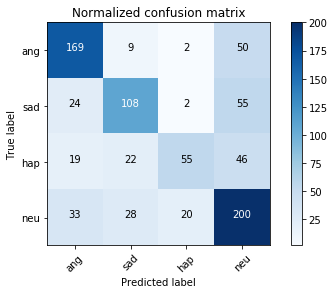

Confusion matrix, without normalization


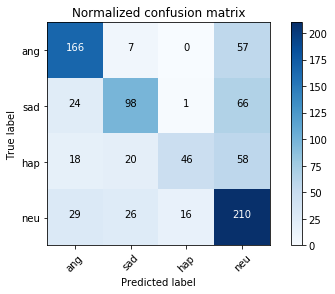

Confusion matrix, without normalization


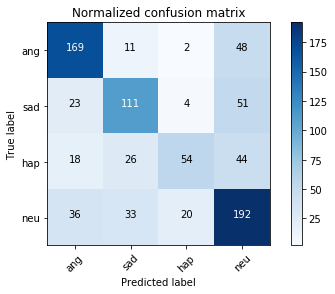

In [273]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,sets_test_data[0],sets_test_data[2],sets_test_data[1])

In [278]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.689795918367347 , 0.7347826086956522
Emo  sad 0.6467065868263473 , 0.5714285714285714
Emo  hap 0.6962025316455697 , 0.3873239436619718
Emo  neu 0.5698005698005698 , 0.7117437722419929
-
Emo  ang 0.6869918699186992 , 0.7347826086956522
Emo  sad 0.6132596685082873 , 0.5873015873015873
Emo  hap 0.675 , 0.38028169014084506
Emo  neu 0.573134328358209 , 0.6832740213523132
-
Emo  ang 0.70042194092827 , 0.7217391304347827
Emo  sad 0.6490066225165563 , 0.5185185185185185
Emo  hap 0.7301587301587301 , 0.323943661971831
Emo  neu 0.5370843989769821 , 0.7473309608540926
0.6411583441119958 0.6318289786223278
0.6304215602114297 0.6247030878859857
0.6393854558957279 0.6175771971496437


# Multichannel CNN - MFCC1 + RMSE + ZCR

## Build Multichannel Frequency Vectors

In [275]:
NUM_CHANNELS = 4
type_matrices = [full_matrices,wc_matrices,cw_matrices]
sets_data = []
sets_test_data = []
for dt_data in type_matrices: 
    acoustic_matrices = [dt_data[0]]
    acoustic_matrices.append(dt_data[RMSE_INDEX])
    acoustic_matrices.append(dt_data[ZCR_INDEX])
    for i,am in enumerate(acoustic_matrices):
        acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
    vector_data = []
    for key, row in vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        vector_data.append(final)

    test_vector_data = []
    for key, row in test_vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        test_vector_data.append(final)
        
    sets_data.append(vector_data)
    sets_test_data.append(test_vector_data)


## Overall Model Training

In [276]:
full_model, wc_model, cw_model , histories = run_models(sets_data[0],sets_test_data[0],sets_data[1],sets_test_data[1],sets_data[2],sets_test_data[2])

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 33s 10ms/step - loss: 1.2363 - acc: 0.7513 - val_loss: 1.2234 - val_acc: 0.7527
Epoch 2/50
3366/3366 [==============================] - 28s 8ms/step - loss: 1.1924 - acc: 0.7571 - val_loss: 1.1936 - val_acc: 0.7550
Epoch 3/50
3366/3366 [==============================] - 28s 8ms/step - loss: 1.1570 - acc: 0.7654 - val_loss: 1.1675 - val_acc: 0.7622
Epoch 4/50
3366/3366 [==============================] - 30s 9ms/step - loss: 1.1248 - acc: 0.7761 - val_loss: 1.1452 - val_acc: 0.7663
Epoch 5/50
3366/3366 [==============================] - 29s 9ms/step - loss: 1.0981 - acc: 0.7854 - val_loss: 1.1223 - val_acc: 0.7726
Epoch 6/50
3366/

Epoch 14/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.9103 - acc: 0.8435 - val_loss: 0.9680 - val_acc: 0.8070
Epoch 15/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.8958 - acc: 0.8493 - val_loss: 0.9566 - val_acc: 0.8085
Epoch 16/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.8831 - acc: 0.8505 - val_loss: 0.9454 - val_acc: 0.8106
Epoch 17/50
3366/3366 [==============================] - 23s 7ms/step - loss: 0.8691 - acc: 0.8487 - val_loss: 0.9330 - val_acc: 0.8118
Epoch 18/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.8549 - acc: 0.8541 - val_loss: 0.9229 - val_acc: 0.8115
Epoch 19/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.8450 - acc: 0.8539 - val_loss: 0.9093 - val_acc: 0.8144
Epoch 20/50
3366/3366 [==============================] - 24s 7ms/step - loss: 0.8349 - acc: 0.8548 - val_loss: 0.9001 - val_acc: 0.8162
Epoch 21/50
3366/3366 [=========================

## Save Model

In [277]:
full_model.save('cnn_models/binmfcc1rmsezcr_full.h5')
cw_model.save('cnn_models/binmfcc1rmsezcr_cw.h5')
wc_model.save('cnn_models/binmfcc1rmsezcr_wc.h5')

# full_model = keras.models.load_model('cnn_models/binrmsezcr_full.h5')
# cw_model = keras.models.load_model('cnn_models/binrmsezcr_cw.h5')
# wc_model = keras.models.load_model('cnn_models/binrmsezcr_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 3s 4ms/step
Confusion matrix, without normalization


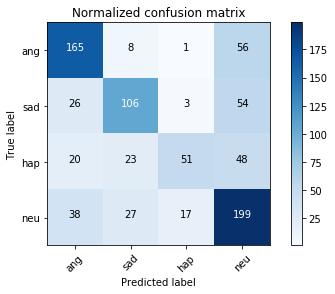

Confusion matrix, without normalization


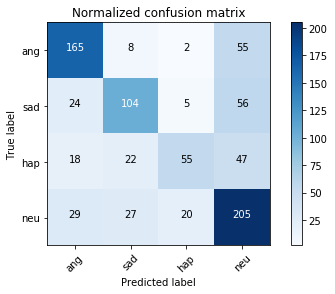

Confusion matrix, without normalization


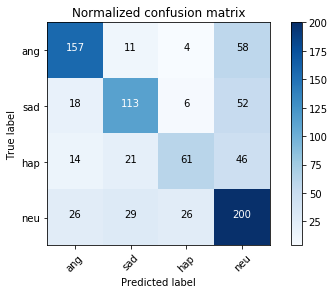

In [280]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,sets_test_data[0],sets_test_data[2],sets_test_data[1])

In [281]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.6626506024096386 , 0.717391304347826
Emo  sad 0.6463414634146342 , 0.5608465608465608
Emo  hap 0.7083333333333334 , 0.3591549295774648
Emo  neu 0.5574229691876751 , 0.708185053380783
-
Emo  ang 0.7302325581395349 , 0.6826086956521739
Emo  sad 0.6494252873563219 , 0.5978835978835979
Emo  hap 0.6288659793814433 , 0.4295774647887324
Emo  neu 0.5617977528089888 , 0.7117437722419929
-
Emo  ang 0.6991525423728814 , 0.717391304347826
Emo  sad 0.6459627329192547 , 0.5502645502645502
Emo  hap 0.6707317073170732 , 0.3873239436619718
Emo  neu 0.5647382920110193 , 0.7295373665480427
0.63157644039745 0.6187648456057007
0.638787417213692 0.6306413301662708
0.6375622372465828 0.6282660332541568


# Multichannel CNN - MFCC1 + RMSE

## Build Multichannel Frequency Vectors

In [282]:
NUM_CHANNELS = 3
type_matrices = [full_matrices,wc_matrices,cw_matrices]
sets_data = []
sets_test_data = []
for dt_data in type_matrices: 
    acoustic_matrices = [dt_data[0]]
    acoustic_matrices.append(dt_data[RMSE_INDEX])
#     acoustic_matrices.append(dt_data[ZCR_INDEX])
    for i,am in enumerate(acoustic_matrices):
        acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
    vector_data = []
    for key, row in vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        vector_data.append(final)

    test_vector_data = []
    for key, row in test_vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        test_vector_data.append(final)
        
    sets_data.append(vector_data)
    sets_test_data.append(test_vector_data)


## Overall Model Training

In [283]:
full_model, wc_model, cw_model , histories = run_models(sets_data[0],sets_test_data[0],sets_data[1],sets_test_data[1],sets_data[2],sets_test_data[2])

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 25s 7ms/step - loss: 1.2276 - acc: 0.7515 - val_loss: 1.2166 - val_acc: 0.7500
Epoch 2/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.1853 - acc: 0.7555 - val_loss: 1.1888 - val_acc: 0.7545
Epoch 3/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.1516 - acc: 0.7658 - val_loss: 1.1633 - val_acc: 0.7625
Epoch 4/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.1201 - acc: 0.7753 - val_loss: 1.1412 - val_acc: 0.7675
Epoch 5/50
3366/3366 [==============================] - 19s 6ms/step - loss: 1.0947 - acc: 0.7860 - val_loss: 1.1214 - val_acc: 0.7729
Epoch 6/50
3366/3

Epoch 14/50
3366/3366 [==============================] - 21s 6ms/step - loss: 0.9409 - acc: 0.8343 - val_loss: 0.9947 - val_acc: 0.7990
Epoch 15/50
3366/3366 [==============================] - 22s 7ms/step - loss: 0.9269 - acc: 0.8362 - val_loss: 0.9822 - val_acc: 0.8023
Epoch 16/50
3366/3366 [==============================] - 22s 6ms/step - loss: 0.9117 - acc: 0.8398 - val_loss: 0.9697 - val_acc: 0.8046
Epoch 17/50
3366/3366 [==============================] - 19s 6ms/step - loss: 0.9015 - acc: 0.8400 - val_loss: 0.9578 - val_acc: 0.8064
Epoch 18/50
3366/3366 [==============================] - 19s 6ms/step - loss: 0.8864 - acc: 0.8423 - val_loss: 0.9466 - val_acc: 0.8082
Epoch 19/50
3366/3366 [==============================] - 18s 5ms/step - loss: 0.8770 - acc: 0.8422 - val_loss: 0.9361 - val_acc: 0.8073
Epoch 20/50
3366/3366 [==============================] - 18s 5ms/step - loss: 0.8620 - acc: 0.8449 - val_loss: 0.9240 - val_acc: 0.8126
Epoch 21/50
3366/3366 [=========================

## Save Model

In [284]:
# full_model.save('cnn_models/binmfcc1rmse_full.h5')
# cw_model.save('cnn_models/binmfcc1rmse_cw.h5')
# wc_model.save('cnn_models/binmfcc1rmse_wc.h5')

full_model = keras.models.load_model('cnn_models/binmfcc1rmse_full.h5')
cw_model = keras.models.load_model('cnn_models/binmfcc1rmse_cw.h5')
wc_model = keras.models.load_model('cnn_models/binmfcc1rmse_wc.h5')

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 1s 936us/step
Confusion matrix, without normalization


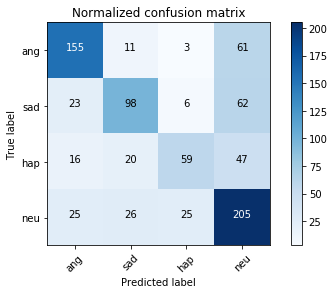

Confusion matrix, without normalization


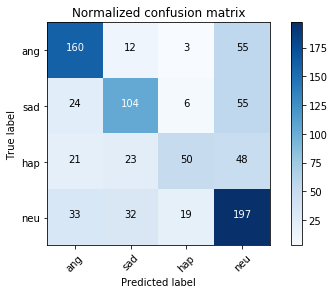

Confusion matrix, without normalization


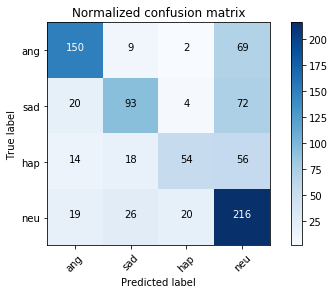

In [289]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,sets_test_data[0],sets_test_data[2],sets_test_data[1])

In [290]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.7077625570776256 , 0.6739130434782609
Emo  sad 0.632258064516129 , 0.5185185185185185
Emo  hap 0.6344086021505376 , 0.4154929577464789
Emo  neu 0.5466666666666666 , 0.7295373665480427
-
Emo  ang 0.7389162561576355 , 0.6521739130434783
Emo  sad 0.636986301369863 , 0.49206349206349204
Emo  hap 0.675 , 0.38028169014084506
Emo  neu 0.5230024213075061 , 0.7686832740213523
-
Emo  ang 0.6722689075630253 , 0.6956521739130435
Emo  sad 0.6081871345029239 , 0.5502645502645502
Emo  hap 0.6410256410256411 , 0.352112676056338
Emo  neu 0.5549295774647888 , 0.701067615658363
0.6246811367697291 0.6140142517814727
0.6332005110006763 0.6092636579572447
0.6134561394938185 0.6068883610451307


# Multichannel CNN - MFCC1 + ZCR

## Build Multichannel Frequency Vectors

In [291]:
NUM_CHANNELS = 3
type_matrices = [full_matrices,wc_matrices,cw_matrices]
sets_data = []
sets_test_data = []
for dt_data in type_matrices: 
    acoustic_matrices = [dt_data[0]]
#     acoustic_matrices.append(dt_data[RMSE_INDEX])
    acoustic_matrices.append(dt_data[ZCR_INDEX])
    for i,am in enumerate(acoustic_matrices):
        acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
    vector_data = []
    for key, row in vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        vector_data.append(final)

    test_vector_data = []
    for key, row in test_vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        test_vector_data.append(final)
        
    sets_data.append(vector_data)
    sets_test_data.append(test_vector_data)


## Overall Model Training

In [292]:
full_model, wc_model, cw_model , histories = run_models(sets_data[0],sets_test_data[0],sets_data[1],sets_test_data[1],sets_data[2],sets_test_data[2])

Running iteration 1/3
Creating CNN 0.0.1
#############################################
Embedding:    no pre-trained embedding
Embedding dim: 4
Filter sizes: [1, 1, 1]
Feature maps: [150, 150, 150]
Max sequence: 170
#############################################
Train on 3366 samples, validate on 842 samples
Epoch 1/50
3366/3366 [==============================] - 28s 8ms/step - loss: 1.2480 - acc: 0.7501 - val_loss: 1.2306 - val_acc: 0.7512
Epoch 2/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.2062 - acc: 0.7554 - val_loss: 1.2037 - val_acc: 0.7527
Epoch 3/50
3366/3366 [==============================] - 20s 6ms/step - loss: 1.1735 - acc: 0.7623 - val_loss: 1.1819 - val_acc: 0.7657
Epoch 4/50
3366/3366 [==============================] - 21s 6ms/step - loss: 1.1445 - acc: 0.7694 - val_loss: 1.1588 - val_acc: 0.7681
Epoch 5/50
3366/3366 [==============================] - 21s 6ms/step - loss: 1.1176 - acc: 0.7780 - val_loss: 1.1369 - val_acc: 0.7708
Epoch 6/50
3366/3

Epoch 14/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.9358 - acc: 0.8327 - val_loss: 0.9897 - val_acc: 0.8026
Epoch 15/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.9202 - acc: 0.8392 - val_loss: 0.9772 - val_acc: 0.8055
Epoch 16/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.9063 - acc: 0.8411 - val_loss: 0.9635 - val_acc: 0.8064
Epoch 17/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.8923 - acc: 0.8402 - val_loss: 0.9519 - val_acc: 0.8091
Epoch 18/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.8783 - acc: 0.8467 - val_loss: 0.9404 - val_acc: 0.8094
Epoch 19/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.8662 - acc: 0.8482 - val_loss: 0.9297 - val_acc: 0.8097
Epoch 20/50
3366/3366 [==============================] - 15s 5ms/step - loss: 0.8555 - acc: 0.8492 - val_loss: 0.9183 - val_acc: 0.8138
Epoch 21/50
3366/3366 [=========================

## Save Model

In [293]:
full_model.save('cnn_models/binmfcc1zcr_full.h5')
cw_model.save('cnn_models/binmfcc1zcr_cw.h5')
wc_model.save('cnn_models/binmfcc1zcr_wc.h5')

# full_model = keras.models.load_model('cnn_models/binmfcc1zcr_full.h5')
# cw_model = keras.models.load_model('cnn_models/binmfcc1zcr_cw.h5')
# wc_model = keras.models.load_model('cnn_models/binmfcc1zcr_wc.h5')

In [361]:
patterns

{'Ses01F_impro01_F000': {'.+ me'},
 'Ses01F_impro01_F002': {'.+ a',
  '.+ problem',
  '.+ there',
  'a .+',
  'is .+',
  'is .+ a',
  'is there .+',
  'there .+',
  'there a .+'},
 'Ses01F_impro01_F005': {'.+ change',
  '.+ it',
  '.+ let',
  '.+ let me',
  '.+ me',
  '.+ problem',
  '.+ the',
  'change .+',
  'let .+',
  'let me .+',
  'me .+',
  'me .+ it',
  'problem .+',
  'the .+',
  'well .+'},
 'Ses01F_impro01_F012': {'.+ of',
  '.+ out',
  '.+ out of',
  'of .+',
  'out .+',
  'out of .+'},
 'Ses01F_impro01_M011': {'.+ a',
  '.+ a simple',
  '.+ an',
  '.+ for',
  '.+ for people',
  '.+ form',
  '.+ get',
  '.+ here',
  '.+ i',
  '.+ i just',
  '.+ id',
  '.+ is',
  '.+ is so',
  '.+ just',
  '.+ just a',
  '.+ just need',
  '.+ need',
  '.+ people',
  '.+ so',
  '.+ they',
  '.+ this',
  '.+ this is',
  '.+ understand',
  '.+ when',
  '.+ when they',
  '.+ why',
  'a .+',
  'an .+',
  'for .+',
  'form .+',
  'get .+',
  'here .+',
  'i .+',
  'i .+ need',
  'i just .+',
  'is

## Overall Model ConfMatrix, Precision and Recall

842/842 [==============================] - 3s 3ms/step
Confusion matrix, without normalization


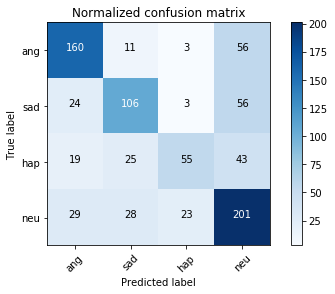

Confusion matrix, without normalization


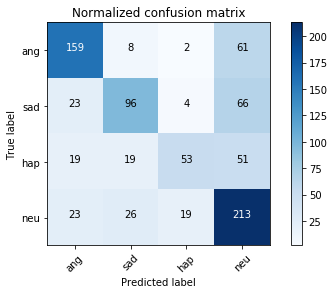

Confusion matrix, without normalization


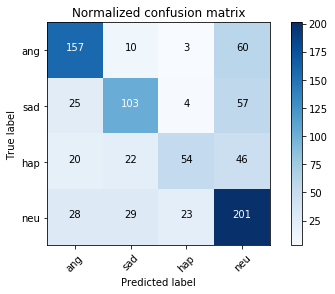

In [294]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,sets_test_data[0],sets_test_data[2],sets_test_data[1])

In [295]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.6896551724137931 , 0.6956521739130435
Emo  sad 0.6235294117647059 , 0.5608465608465608
Emo  hap 0.6547619047619048 , 0.3873239436619718
Emo  neu 0.5646067415730337 , 0.7153024911032029
-
Emo  ang 0.6826086956521739 , 0.6826086956521739
Emo  sad 0.6280487804878049 , 0.544973544973545
Emo  hap 0.6428571428571429 , 0.38028169014084506
Emo  neu 0.5521978021978022 , 0.7153024911032029
-
Emo  ang 0.7098214285714286 , 0.691304347826087
Emo  sad 0.6442953020134228 , 0.5079365079365079
Emo  hap 0.6794871794871795 , 0.3732394366197183
Emo  neu 0.5447570332480819 , 0.7580071174377224
0.6271952889987111 0.6199524940617577
0.6201360050065224 0.6116389548693587
0.6349105065105178 0.6187648456057007


# Others

In [374]:
full_model = keras.models.load_model('cnn_models/binmfcc20_rmsezcr_full.h5')
cw_model = keras.models.load_model('cnn_models/binmfcc20_rmsezcr_cw.h5')
wc_model = keras.models.load_model('cnn_models/binmfcc20_rmsezcr_wc.h5')


array([[4.1091174e-01, 3.6733204e-01, 3.8552884e-02, 1.8320331e-01],
       [3.9460132e-01, 3.5029545e-02, 6.9473321e-03, 5.6342185e-01],
       [1.6382436e-01, 4.1888434e-01, 1.5855061e-01, 2.5874066e-01],
       ...,
       [3.1523232e-03, 9.9325258e-01, 2.9675390e-03, 6.2757923e-04],
       [6.7736489e-01, 5.8113273e-02, 6.9588259e-02, 1.9493364e-01],
       [9.8830020e-01, 9.9882102e-03, 1.0387838e-03, 6.7279622e-04]],
      dtype=float32)

In [375]:
NUM_CHANNELS = 23
type_matrices = [full_matrices,wc_matrices,cw_matrices]
sets_data = []
sets_test_data = []
for dt_data in type_matrices:
    acoustic_matrices = dt_data.copy()
#     acoustic_matrices.append(dt_data[RMSE_INDEX])
    for i,am in enumerate(acoustic_matrices):
        acoustic_matrices[i] = acoustic_matrices[i].fillna(np.max(acoustic_matrices[i]))

#######################################
#     vector_data = []
#     for key, row in vectors.iterrows():
#         final = []
#         row_patt = [ i for i,v in row.iteritems() if v == 1]
#         row_matrix = em_df.loc[row_patt,:].as_matrix()
#         pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
#         pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
#         final.append(pad)
#         ### ACU MATRICES ###
#         for i,am in enumerate(acoustic_matrices):
#             acu_matrix = am.loc[row_patt,:].as_matrix()
#             acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
#             acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
#             final.append(acu_pad)
#         vector_data.append(final)

    test_vector_data = []
    for key, row in test_vectors.iterrows():
        final = []
        row_patt = [ i for i,v in row.iteritems() if v == 1]
        row_matrix = em_df.loc[row_patt,:].as_matrix()
        pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
        pad[:row_matrix.shape[0],:row_matrix.shape[1]] = row_matrix
        final.append(pad)
        ### ACU MATRICES ###
        for i,am in enumerate(acoustic_matrices):
            acu_matrix = am.loc[row_patt,:].as_matrix()
            acu_pad = np.zeros((MAX_SEQ_LENGTH,EMBEDDING_DIM))
            acu_pad[:acu_matrix.shape[0],:acu_matrix.shape[1]] = acu_matrix
            final.append(acu_pad)
        test_vector_data.append(final)
        
    sets_data.append(vector_data)
    sets_test_data.append(test_vector_data)


In [378]:
full_predictions = full_model.predict([sets_test_data[0]],verbose=1)
wc_predictions = wc_model.predict([sets_test_data[1]],verbose=1)
cw_predictions = cw_model.predict([sets_test_data[2]],verbose=1)
# baseline_predictions

842/842 [==============================] - 7s 9ms/step


842/842 [==============================] - 7s 9ms/step
Normalized confusion matrix


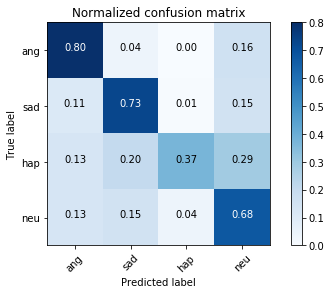

Normalized confusion matrix


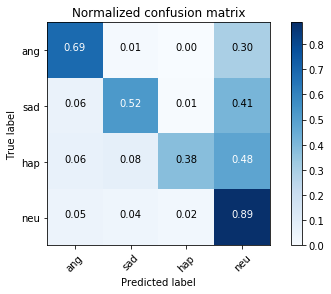

Normalized confusion matrix


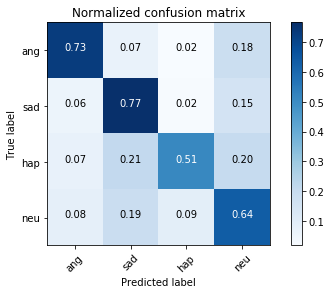

Accuracy
Full 0.671021377672209
CW 0.665083135391924
WC 0.671021377672209


In [368]:
full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix, precisions,recalls = get_metrics(full_model,wc_model,cw_model,sets_test_data[0],sets_test_data[2],sets_test_data[1])

In [365]:
get_precision_recall(full_cnf_matrix,wc_cnf_matrix,cw_cnf_matrix)
print(precisions[0],recalls[0])
print(precisions[1],recalls[1])
print(precisions[2],recalls[2])

Emo  ang 0.7049808429118773 , 0.8
Emo  sad 0.6301369863013698 , 0.7301587301587301
Emo  hap 0.8153846153846154 , 0.3732394366197183
Emo  neu 0.6397306397306397 , 0.6761565836298933
-
Emo  ang 0.7924528301886793 , 0.7304347826086957
Emo  sad 0.5942622950819673 , 0.7671957671957672
Emo  hap 0.6822429906542056 , 0.5140845070422535
Emo  neu 0.6415770609318996 , 0.6370106761565836
-
Emo  ang 0.8229166666666666 , 0.6869565217391305
Emo  sad 0.7983870967741935 , 0.5238095238095238
Emo  hap 0.8709677419354839 , 0.38028169014084506
Emo  neu 0.5366379310344828 , 0.8861209964412812
0.6850242392275722 0.671021377672209
0.6790277713879442 0.671021377672209
0.7299746705453495 0.665083135391924


In [381]:
true_predictions = np.argmax(y_test,axis=1)
full_pred = np.argmax(full_predictions,axis =1)
wc_pred = np.argmax(wc_predictions,axis=1)
cw_pred = np.argmax(cw_predictions,axis=1)
base_pred = np.argmax(baseline_predictions,axis=1)

In [423]:
i = 0
improvements = []
texts = X_test.text.values
for true,baseline,model,model2,model3 in zip(true_predictions,base_pred,cw_pred,wc_pred,full_pred):
    if(baseline != true and model == true): 
        X_test.iloc[i]
#         print(texts[i])
        improvements.append(i)
        print(texts[i]+' &' +EMO_SET[baseline]+ ' &'+EMO_SET[model]+ '& '+ '&'+EMO_SET[true]+ ' \\\\ \hline')
    i += 1


well apparently nobody else can go &ang &sad& &sad \\ \hline
close to thirty oof it's going to be tough &sad &neu& &neu \\ \hline
it must be really really hard to lose a child &neu &sad& &sad \\ \hline
thanks that helps &sad &ang& &ang \\ \hline
uh so it was really heavy &sad &neu& &neu \\ \hline
to make up the three million dollars &ang &neu& &neu \\ \hline
give me a kiss ann give me a &ang &hap& &hap \\ \hline
but i need to speak to somebody who can make the three check thing happen &neu &ang& &ang \\ \hline
the worst one was in cannes when your curling iron burnt a hole in my new dressing gown &ang &neu& &neu \\ \hline
so you're leaving tomorrow &neu &sad& &sad \\ \hline
yeah i know i was in the country i mean it's not that complicated &sad &neu& &neu \\ \hline
you know sometimes you think you want to make that phone call or you think you want to tell somebody something or something like that do you know what i mean like that's he was the person that i did that with you know like th

In [414]:
X_test.loc[:,['text','emotion']].iloc[improvements]

,text,emotion
7942,well apparently nobody else can go,sad
1292,what can you prove it what proof do you have c...,ang
8333,it must be really really hard to lose a child,sad
5832,thanks that helps,ang
4036,to make up the three million dollars,neu
7788,yes i did quite a lot,ang
9092,i know i know i know but you know what that do...,sad
7156,but i need to speak to somebody who can make t...,ang
1800,did you see much of peter burden after our div...,ang
2610,the worst one was in cannes when your curling ...,neu


In [370]:
get_scores_from_multiple('history/rmse/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
2,_FS1_1_1_FM_150_data_cw.pkl,0.843568,0.810036,0.917972,0.983671
7,_FS1_1_1_FM_150_data_wc.pkl,0.843078,0.809026,0.913673,0.978675
12,_FS1_1_1_FM_150_data_full.pkl,0.842736,0.808670,0.916785,0.981181
17,_FS1_1_1_FM_100_data_full.pkl,0.836557,0.804810,0.944705,1.005316
15,_FS1_2_2_FM_150_data_wc.pkl,0.837394,0.804632,0.876767,0.936163
0,_FS1_2_3_FM_150_data_full.pkl,0.833754,0.804137,0.854709,0.910466
11,_FS1_2_2_FM_150_data_cw.pkl,0.835710,0.802751,0.876312,0.934580
3,_FS1_2_2_FM_150_data_full.pkl,0.838879,0.802652,0.867716,0.928262
9,_FS1_2_3_FM_150_data_cw.pkl,0.834769,0.802553,0.860108,0.917960
4,_FS1_2_3_FM_150_data_wc.pkl,0.833309,0.802454,0.851820,0.908359


In [369]:
get_scores_from_multiple('history/zcr/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
7,_FS1_1_1_FM_150_data_wc.pkl,0.844177,0.810669,0.924053,0.989819
12,_FS1_1_1_FM_150_data_full.pkl,0.843212,0.809580,0.920701,0.985644
2,_FS1_1_1_FM_150_data_cw.pkl,0.845663,0.807898,0.903753,0.971623
11,_FS1_2_2_FM_150_data_cw.pkl,0.837369,0.804236,0.867452,0.928122
15,_FS1_2_2_FM_150_data_wc.pkl,0.837765,0.803741,0.872488,0.932890
9,_FS1_2_3_FM_150_data_cw.pkl,0.834497,0.803543,0.849514,0.906334
3,_FS1_2_2_FM_150_data_full.pkl,0.836849,0.803444,0.873684,0.933032
8,_FS1_3_5_FM_150_data_wc.pkl,0.834348,0.802949,0.819095,0.875479
0,_FS1_2_3_FM_150_data_full.pkl,0.834398,0.801267,0.858987,0.916440
4,_FS1_2_3_FM_150_data_wc.pkl,0.836205,0.801168,0.853527,0.911965


In [320]:
get_scores_from_multiple('history/mfcc20/').sort_values(by='Valid Acc',ascending=False)

,Model,Train Acc,Valid Acc,Train Loss,Valid Loss
4,_FS5_5_5_FM_150_data_wc.pkl,0.868390,0.830166,0.731981,0.794997
1,_FS1_1_1_FM_150_data_wc.pkl,0.876114,0.827791,0.878958,0.956947
2,_FS1_1_1_FM_150_data_full.pkl,0.871806,0.826603,0.870234,0.949695
5,_FS5_5_5_FM_150_data_full.pkl,0.860368,0.822743,0.742465,0.803504
3,_FS5_5_5_FM_150_data_cw.pkl,0.858214,0.821259,0.744098,0.805539
0,_FS1_1_1_FM_150_data_cw.pkl,0.866310,0.819774,0.902511,0.978611


,index,start_time,end_time,text,wav_path,alignment_path,emotion,valence,arousal,dominance,gender,emotion_code
6826,Ses04F_script03_2_M001,11.7147,15.89,i knew nothing of the sort you took presents f...,data/IEMOCAP_full_release/Session4/sentences/w...,data/IEMOCAP_full_release/Session4/sentences/F...,ang,2.5,3,4,M,0
9762,Ses05M_script02_1_F016,227.02,228.75,i'm just not,data/IEMOCAP_full_release/Session5/sentences/w...,data/IEMOCAP_full_release/Session5/sentences/F...,sad,2,2.5,3,F,1
6440,Ses04F_script01_2_F013,93.46,101.72,i want you to act like he's coming back both o...,data/IEMOCAP_full_release/Session4/sentences/w...,data/IEMOCAP_full_release/Session4/sentences/F...,ang,2,4.5,4.5,F,0
2560,Ses02F_script03_1_F010,56.38,58.73,yes meaning just that,data/IEMOCAP_full_release/Session2/sentences/w...,data/IEMOCAP_full_release/Session2/sentences/F...,hap,3.3333,2,3,F,2
5124,Ses03M_impro08a_F014,118.43,121.23,i want to talk to a supervisor,data/IEMOCAP_full_release/Session3/sentences/w...,data/IEMOCAP_full_release/Session3/sentences/F...,ang,2,3.5,4,F,0
2066,Ses02F_impro06_M014,158.59,160.82,i know it doesn't bring him back but,data/IEMOCAP_full_release/Session2/sentences/w...,data/IEMOCAP_full_release/Session2/sentences/F...,neu,1.6667,2,2,M,3
4177,Ses03F_script01_2_M007,62.2403,65.1005,how do you know why she's waited,data/IEMOCAP_full_release/Session3/sentences/w...,data/IEMOCAP_full_release/Session3/sentences/F...,neu,3,3,2.5,M,3
4982,Ses03M_impro05b_M011,76.2,83.22,i'm going to san diego tomorrow to stay with m...,data/IEMOCAP_full_release/Session3/sentences/w...,data/IEMOCAP_full_release/Session3/sentences/F...,ang,1.5,2.5,4,M,0
3545,Ses02M_script03_2_F006,37.1398,40.1248,it gave him a lot of pleasure it didn't hurt m...,data/IEMOCAP_full_release/Session2/sentences/w...,data/IEMOCAP_full_release/Session2/sentences/F...,neu,3,3,3,F,3
5326,Ses03M_script01_2_F009,73.7734,78.7023,i mean her faith is stronger than a rock,data/IEMOCAP_full_release/Session3/sentences/w...,data/IEMOCAP_full_release/Session3/sentences/F...,ang,2.5,3,3.5,F,0
